# Traffic Flow Simulator

In [1]:
from utils import *
from itertools import repeat, compress, product
#from altair import Chart
import numpy as np
import pandas as pd

## Functions

In [2]:
def simulate(tresholds, weights, agent_counts, route_opts, routes, round_count, road_params,\
             change_percent, t, trpf_use_percent, simulation_name, trip_names):
    
    trips = np.hstack([np.ones(agent_counts[i])*i for i in range(len(agent_counts))])

    roads = []
    road_inds = {}
    for i, params in enumerate(road_params.itertuples(index=False)):
        road = Road(*params)
        roads.append(road)
        road_name = params[0] + params[1] # Node 1 + Node 2
        road_inds[road_name] = i

    route_to_road = {i[0] : np.zeros((len(roads), len(i[1]))) for i in routes.items()}
    for trip, trip_routes in routes.items():
        for i, route in enumerate(trip_routes):
            for e in range(1, len(route)):
                try:
                    road_name = route[e-1] + route[e]
                    j = road_inds[road_name]
                except KeyError:
                    road_name = route[e] + route[e-1]
                    j = road_inds[road_name]

                route_to_road[trip][j, i] = 1

    road_to_route = {i[0]: i[1].T for i in route_to_road.items()}
    route_counts = {i[0]: len(i[1]) for i in road_to_route.items()}

    routes = {i[0]: np.arange(len(i[1])) for i in routes.items()}
    agents = []
    trpf_agents = []
    for tag, trip in zip(range(sum(agent_counts)), trips):
        agent = Agent(tag, tresholds, weights, trip, routes, change_percent, trpf_use_percent)
        agents.append(agent)
        if agent.uses_trpf():
            trpf_agents.append(agent)

    trpf = Trpf(routes, round_count, t)

    data = pd.DataFrame(columns = ['Trip', 'Route', 'Count', 'Cost', 'Trpf', 'Round'])
    data2 = pd.DataFrame(columns=['Trip', 'AverageCost', 'Round'])

    print('G:{}, T:{}, P:{}'.format(change_percent, t, trpf_use_percent))

    while trpf.start_new_round():
        choices, route_traveller_counts = get_route_choices(agents, routes)

        excess_traveller_counts = {i[0]: np.absolute(i[1]-j[1]) for i, j in zip(route_traveller_counts.items(), \
            route_opts.items())}

        route_costs = get_route_costs(roads, choices, route_traveller_counts, route_to_road, road_to_route)

        give_costs(agents, route_costs)    

        get_reports(agents, trpf, choices, excess_traveller_counts)

        route_trpfs = trpf.calculate_trpf()
        give_trpfs(trpf_agents, route_trpfs)

        # Save the choices    
        overall_cost = 0
        for trip, trip_routes in routes.items():
            total_trip_cost = 0
            for route in trip_routes:
                route_cost = route_costs[trip][route]
                route_trpf = route_trpfs[trip][route]
                route_traveller_count = route_traveller_counts[trip][route]

                total_trip_cost += route_cost * route_traveller_count

                data.loc[data.shape[0]] = [trip, route, route_traveller_count, \
                                                        route_cost, route_trpf, trpf.current_round]
            overall_cost += total_trip_cost 
            average_trip_cost = total_trip_cost / agent_counts[trip]
            data2.loc[data2.shape[0]] = [trip, average_trip_cost, trpf.current_round]

        average_cost = overall_cost / sum(agent_counts)
        data2.loc[data2.shape[0]] = ['Overall', average_cost, trpf.current_round]
        
    # Drop the first 100 rounds
    data_by_trips = data2.drop(['Round'], axis=1).groupby('Trip')

    means = data_by_trips.mean()
    means.columns = ['CostMean']

    stds = data_by_trips.std()
    stds.columns = ['CostStd']

    stats = pd.concat([means, stds], axis=1)
    stats = stats.values.flatten()[np.newaxis,:]

    trips = trip_names
    aggrs = ['Average', 'Std']
    columns = pd.MultiIndex.from_product([trips, aggrs])
    index = pd.MultiIndex.from_tuples([(change_percent, t, trpf_use_percent)], names=['G', 'T', 'P'])

    report = pd.DataFrame(stats, index=index, columns=columns)

    # Add the report to the excel
    try:
        xl = pd.read_excel("experiment_results.xlsx", header=[0,1], index_col=[0,1,2], sheetname=simulation_name)
        xl.loc[change_percent, t, trpf_use_percent] = report.values.flatten()
        writer = pd.ExcelWriter('experiment_results.xlsx', engine='xlsxwriter')
        xl.to_excel(writer, sheet_name=simulation_name)
        writer.save()
    except:
        writer = pd.ExcelWriter('experiment_results.xlsx', engine='xlsxwriter')
        report.to_excel(writer, sheet_name=simulation_name)
        writer.save()
    
    return data, data2

## Read the configuration

In [3]:
simulation_name = 'SimpleNet'
simulation_folder = '/home/ihsan/Research/TrafficFlowSimulator/simulations/'
traffic_file = simulation_folder + simulation_name + '/traffic.properties'
roadnet_file = simulation_folder + simulation_name + '/roadnet.csv'

config = read_config(traffic_file, roadnet_file)

tresholds = config['tresholds']
weights = config['weights']   
g_values = config['g_values']
t_values = config['t_values']
agent_counts = config['agent_counts']
p_values = config['p_values']
routes = config['routes']
route_opts = config['route_opts']
round_count = config['round_count']
road_params = config['road_params']
trip_names = config['trip_names']
trip_names.append('Overall')

print('Tresholds: {}'.format(tresholds))
print('Weights: {}'.format(weights))
print('G Values: {}'.format(g_values))
print('T Values: {}'.format(t_values))
print('Agent Counts by Trip: {}'.format(agent_counts))
print('P Values: {}'.format(p_values))
print('Route Optimums by Trip: {}'.format(route_opts))
print('Round Count: {}'.format(round_count))
print('Routes: {}'.format(routes)) # Trips are 0:AL, 1:AM, 2:BL, 3BM

Tresholds: [10, 20, 50]
Weights: [3, 5, 7]
G Values: [0.2]
T Values: [3]
Agent Counts by Trip: [200]
P Values: [1.0]
Route Optimums by Trip: {0: [100.0, 100.0]}
Round Count: 100
Routes: {0: [['S', 'M', 'D'], ['S', 'N', 'D']]}


## Multiple simulations

In [4]:
values = product(g_values, t_values, p_values)
for params in values:
    simulate(tresholds, weights, agent_counts, route_opts, routes, round_count, road_params, *params, simulation_name, trip_names)

G:0.2, T:3, P:1.0


/home/ihsan/Research/TrafficFlowSimulator/utils.py:268: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  route_traveller_counts[trip][route] += 1


## Single Simulation

In [11]:
g = 0.5
t = 5
p = 0.8

data, data2 = simulate(tresholds, [1, 3, 5], agent_counts, route_opts, routes, round_count, road_params, g, t, p, simulation_name, trip_names)

G:0.5, T:5, P:0.8


/home/ihsan/Research/TrafficFlowSimulator/utils.py:268: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  route_traveller_counts[trip][route] += 1


In [21]:
# Drop the first 100 rounds
data_by_trips = data2.drop(['Round'], axis=1).groupby('Trip')

means = data_by_trips.mean()
means.columns = ['CostMean']

stds = data_by_trips.std()
stds.columns = ['CostStd']

stats = pd.concat([means, stds], axis=1)
stats = stats.values.flatten()[np.newaxis,:]

trips = trip_names
aggrs = ['Average', 'Std']
columns = pd.MultiIndex.from_product([trips, aggrs])
index = pd.MultiIndex.from_tuples([(0.5, 5, 0.8)], names=['G', 'T', 'P'])

report = pd.DataFrame(stats, index=index, columns=columns)

# Add the report to the excel
try:
    xl = pd.read_excel("experiment_results.xlsx", header=[0,1], index_col=[0,1,2], sheetname=simulation_name)
    xl.loc[change_percent, t, trpf_use_percent] = report.values.flatten()
    writer = pd.ExcelWriter('experiment_results.xlsx', engine='xlsxwriter')
    xl.to_excel(writer, sheet_name=simulation_name)
    writer.save()
except:
    writer = pd.ExcelWriter('experiment_results.xlsx', engine='xlsxwriter')
    report.to_excel(writer, sheet_name=simulation_name)
    writer.save()

# Visualizations

In [22]:
report

S1T1                 S2T2              Overall         
             Average       Std    Average       Std    Average      Std
G   T P                                                                
0.5 5 0.8  35.778816  3.079491  32.815811  4.039754  34.297313  3.31609

## Average Cost per Route per Round

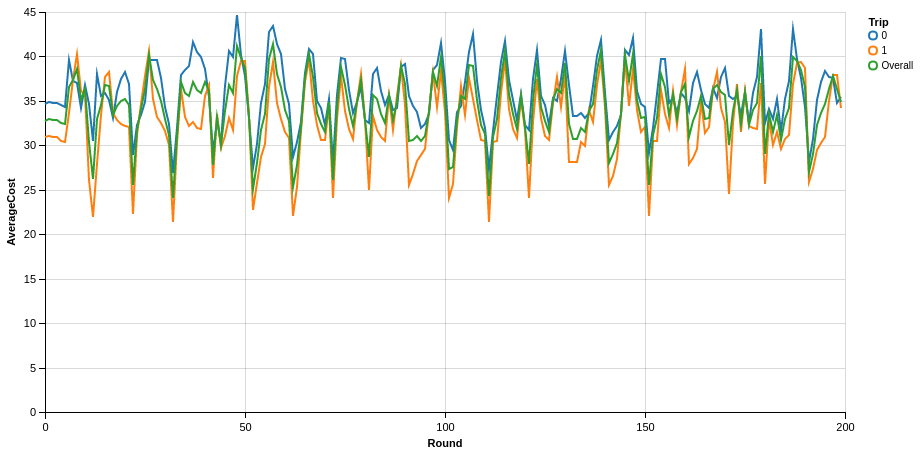

In [20]:
chart = Chart(data2).mark_line().encode(x='Round:Q', y='AverageCost:Q', color='Trip:N')
chart.configure_cell(height=400, width=800)